In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#載入波士頓房價資料集
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [4]:
train_data.shape,test_data.shape

((404, 13), (102, 13))

In [5]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [6]:
#正規化資料
mean=train_data.mean(axis=0)#沿著第0軸(batch_size軸)算平均
train_data=train_data-mean
std=train_data.std(axis=0)#沿著第0軸(batch_size軸)算標準差
train_data=train_data/std

test_data=test_data-mean
test_data=test_data/std

In [7]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [8]:
#模型定義
from keras import models
from keras import layers
def build_model():
  model=models.Sequential()
  model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])#mse為均方差，mae為平均絕對誤差
  return model

In [9]:
#利用 K折驗證來驗證模型的成效
k=4#進行4折交叉驗證
num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]
for i in range(k):
  print('processing fold#',i)
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]#準備驗證資料
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
  partial_train_data=np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)#準備訓練資料
  partial_train_targets=np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
  model=build_model()
  model.fit(partial_train_data,partial_train_targets,batch_size=1,epochs=num_epochs,verbose=0)
  val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)#以驗證資料評估模型
  all_scores.append(val_mae)

processing fold# 0
processing fold# 1
processing fold# 2
processing fold# 3


In [10]:
all_scores

[1.8715310096740723,
 2.6173253059387207,
 2.6663894653320312,
 2.6605968475341797]

In [11]:
#驗證分數的平均
np.mean(all_scores)

2.453960657119751

In [12]:
#改用500個週期來訓練神經網路，並記錄模型在每個週期的表現
num_epochs=500
all_mae_histories=[]
for i in range(k):
  print('processing fold#',i)
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]#準備驗證資料
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
  partial_train_data=np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)#準備訓練資料
  partial_train_targets=np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
  model=build_model()
  history=model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_targets),batch_size=1,epochs=num_epochs,verbose=0)
  mae_history=history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold# 0
processing fold# 1
processing fold# 2
processing fold# 3


In [13]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [14]:
np.array(all_mae_histories).shape

(4, 500)

In [15]:
len(average_mae_history)

500

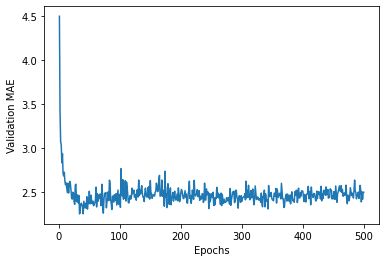

In [16]:
#繪製驗證分數
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

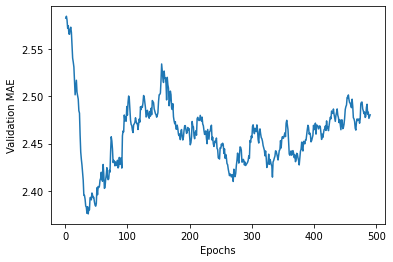

In [22]:
#替換成指數移動平均值(EMA)
def smooth_curve(points,factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous=smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history=smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
# plt.plot(range(1,100+1),smooth_mae_history[:100])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [23]:
len(smooth_mae_history)

490

In [27]:
#訓練最終模型
model=build_model()
model.fit(train_data,train_targets,epochs=70,batch_size=16,verbose=0)
test_mse_score,test_mae_score=model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 18.4466 - mae: 2.5802


In [28]:
test_mae_score

2.580237865447998